In [1]:
import scanpy as sc

### Reading AnnData object with inVAE embedding 

In [7]:
adata_invae = sc.read_h5ad("/lustre/scratch126/cellgen/team292/ha10/data/Spatial_Lung/adata_train_inVAE_processed.h5ad")


In [3]:
sc.settings.set_figure_params(figsize=(3,4))

/home/jovyan/my-conda-envs/general/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


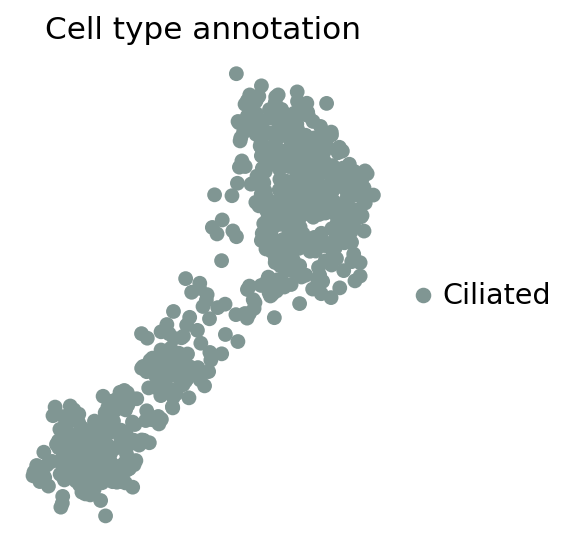

In [4]:
sc.pl.umap(adata_invae[adata_invae.obs.Celltypes.isin(['Ciliated'])],color='Celltypes',frameon=False, title='Cell type annotation')

/home/jovyan/my-conda-envs/general/lib/python3.8/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jovyan/my-conda-envs/general/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


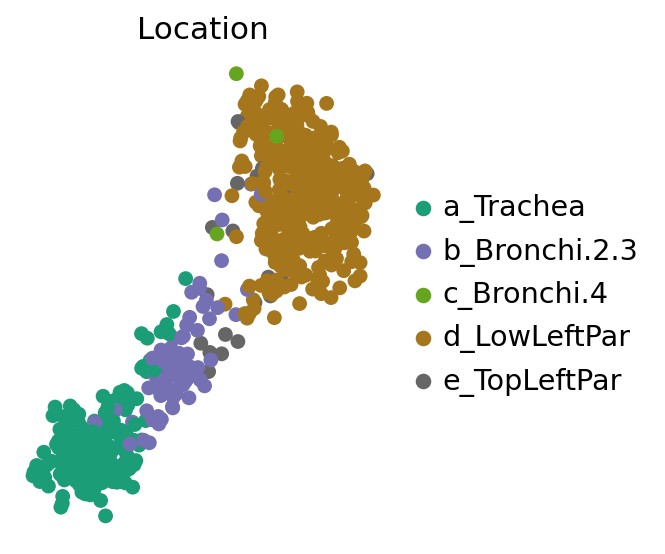

In [5]:
sc.pl.umap(adata_invae[adata_invae.obs.Celltypes.isin(['Ciliated'])],color='Loc_true',frameon=False, title='Location',palette='Dark2')

#### Subset Ciliated object

In [7]:
Ciliated = adata_invae[adata_invae.obs['Celltypes'] == 'Ciliated']

In [8]:
Ciliated = Ciliated.raw.to_adata()

In [9]:
sc.pp.filter_genes(Ciliated, min_cells=3)

### Run HotSpot analysis based on inVAE embedding

In [10]:
import hotspot

In [11]:
from scipy.sparse import csc_matrix
Ciliated.layers["counts"] = csc_matrix(Ciliated.X)

In [12]:
counts = hotspot.Hotspot._counts_from_anndata(Ciliated, 'counts')

In [13]:
hs = hotspot.Hotspot(
    Ciliated,
    model='danb',
    latent_obsm_key="X_FinVAE"
)
hs.create_knn_graph(
    weighted_graph=True, n_neighbors=20,
)

/home/jovyan/my-conda-envs/general/lib/python3.8/site-packages/hotspot/hotspot.py:98: UserWarning: Hotspot will work faster when counts are a csc sparse matrix.
  warnings.warn(


In [1]:
import pickle
with open('./hs_objects/Ciliated_hs_object.obj', 'wb') as f:
    pickle.dump(hs, f)

### Downstream analysis of HS

In [2]:
import pickle
with open('/lustre/scratch126/cellgen/team205/dp26/Lung_5loc/invae/script/hs_objects/Ciliated_hs_object.obj', 'rb') as f:
    hs = pickle.load(f)

In [3]:
Ciliated = hs.adata

In [3]:

hs_results = hs.compute_autocorrelations(jobs=4)

hs_results.head(15)

# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(1000).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=4)


100%|██████████| 19384/19384 [00:42<00:00, 452.75it/s]


Computing pair-wise local correlation on 1000 features...


100%|██████████| 499500/499500 [00:23<00:00, 21612.62it/s]


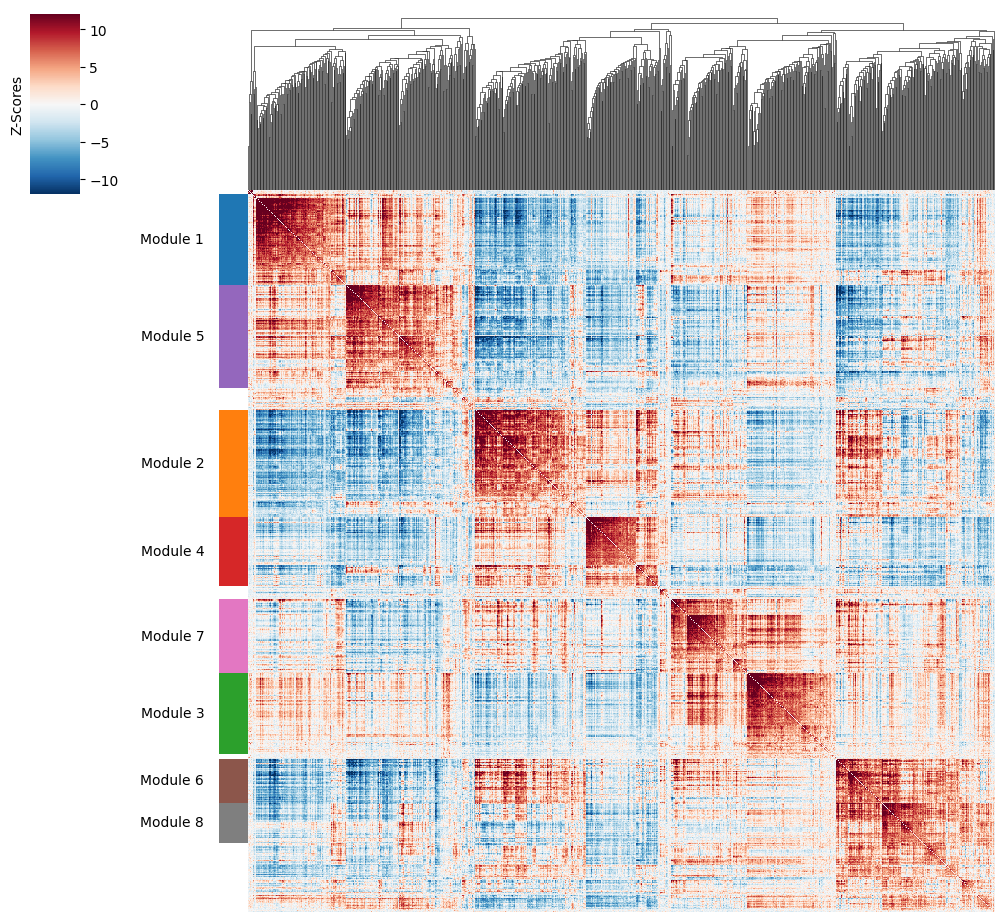

In [74]:
modules = hs.create_modules(
    min_gene_threshold=50, core_only=True, fdr_threshold=0.05
)

hs.plot_local_correlations(vmin=-12, vmax=12)

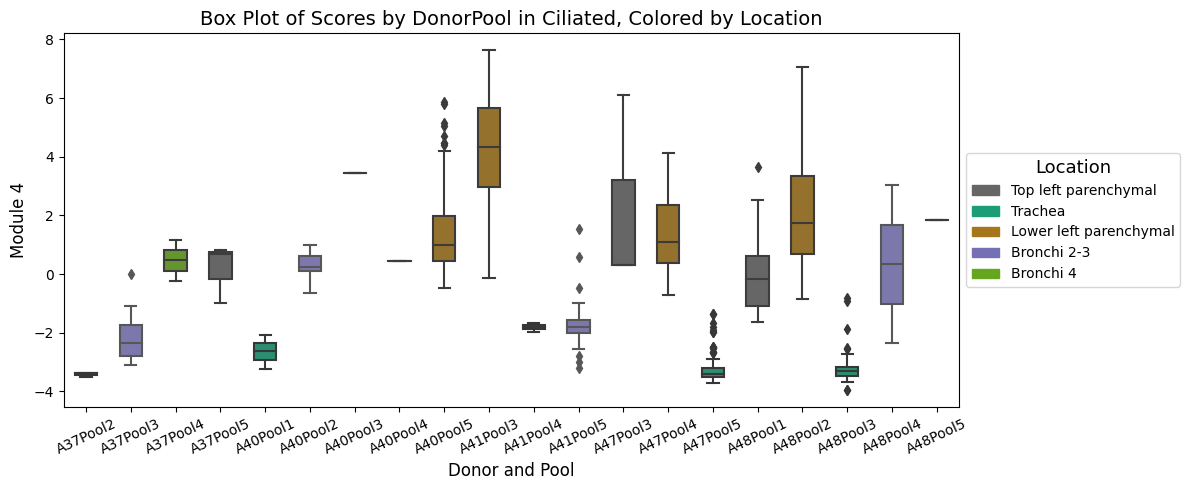

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

colors_dict = {
    'b_Bronchi.2.3':'#7570b3ff', 'c_Bronchi.4':'#66a61eff', 'd_LowLeftPar':'#a6761dff', 'e_TopLeftPar':'#666666ff', 'a_Trachea': '#1b9e77ff'
}

# New names for Loc_true values
new_names = ['Top left parenchymal','Trachea', 'Lower left parenchymal','Bronchi 2-3', 'Bronchi 4']  # Replace with actual new names

# Map the original locations to new names
original_locations = Ciliated.obs['Loc_true'].unique()
location_name_map = dict(zip(original_locations, new_names))

# Initialize the plot
plt.figure(figsize=(12, 5))

# Plot each location separately
for loc in original_locations:
    subset = Ciliated.obs[Ciliated.obs['Loc_true'] == loc]
    sns.boxplot(
        x='DonorPool', y='Module 4', data=subset, 
        color=colors_dict[loc], width=0.5
    )

# Customize axis labels
plt.xlabel('Donor and Pool', fontsize=12)
plt.ylabel('Module 4', fontsize=12)
plt.title('Box Plot of Scores by DonorPool in Ciliated, Colored by Location', fontsize=14)

# Create a custom legend with new names for Loc_true
legend_handles = [mpatches.Patch(color=colors_dict[loc], label=location_name_map[loc]) for loc in original_locations]
plt.legend(handles=legend_handles, title='Location', title_fontsize='13', fontsize='10', loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(rotation=25)
plt.tight_layout()

plt.savefig('figures/Sup/Score_distribution_Ciliated_module_4.pdf', bbox_inches='tight')
plt.show()

In [5]:
module_scores = hs.calculate_module_scores()

Computing scores for 5 modules...


100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


In [7]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    Ciliated.obs[key] = module_scores[c]
    module_cols.append(key)

In [4]:
# Normalizing to median total counts
sc.pp.normalize_total(Ciliated)
# Logarithmize the data
sc.pp.log1p(Ciliated)

/home/jovyan/my-conda-envs/general/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


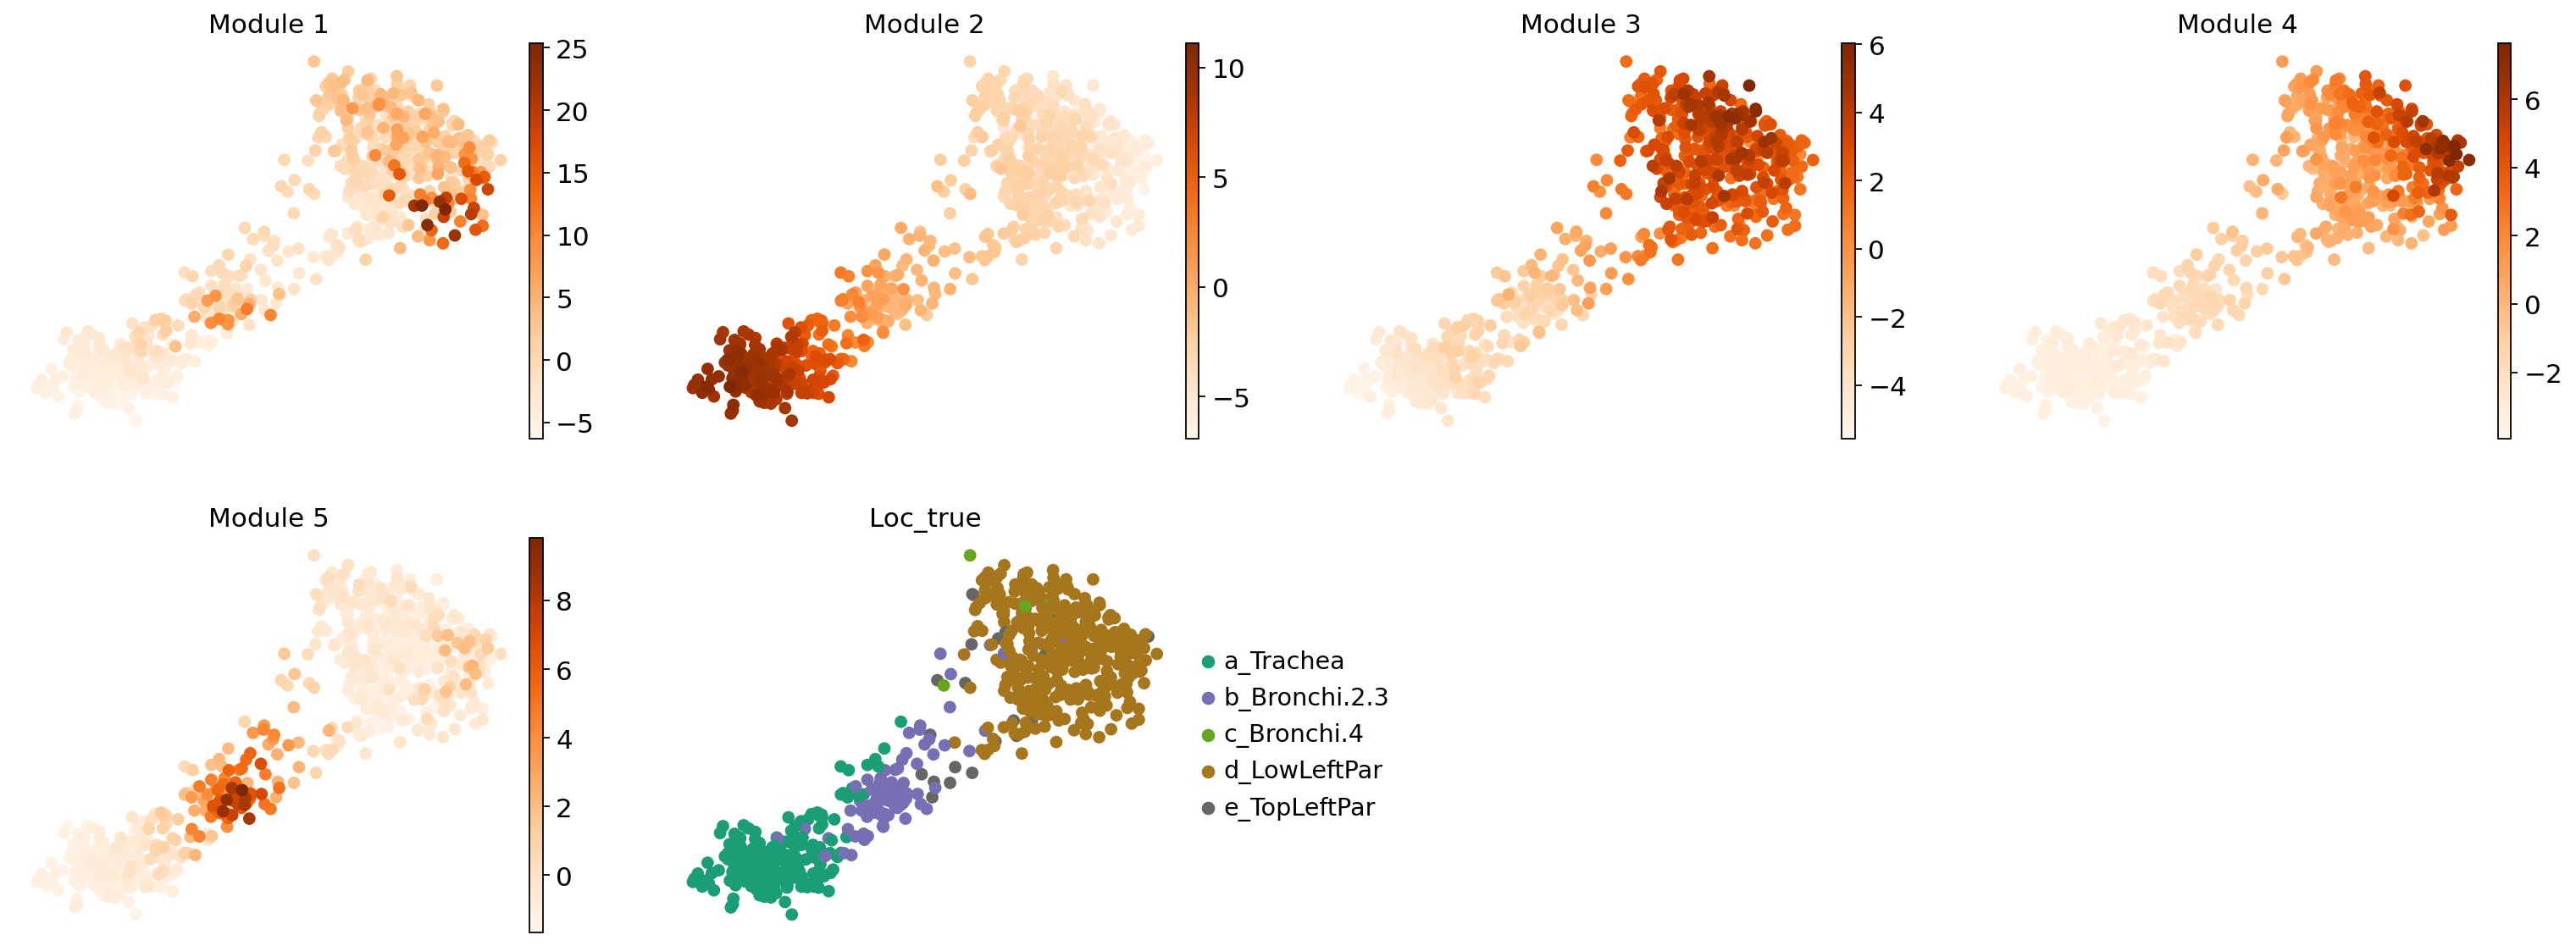

In [9]:
sc.pl.umap(Ciliated, color=module_cols + ['Loc_true'], frameon=False,ncols=4,cmap='Oranges',palette='Dark2',
#            save='_updated_Ciliated_HS_all_modules.pdf'
          )

In [12]:
module = 4

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
PRMT8,0.290290,31.050462,5.622956e-212,5.190256e-209,4.0
GPC3,0.192912,28.781375,1.834614e-182,1.226281e-179,4.0
FTO,0.283987,26.596740,3.701865e-156,1.839922e-153,4.0
CPM,0.236953,25.699681,5.892530e-146,2.538240e-143,4.0
ATP13A4,0.245163,24.772332,8.909127e-136,3.453890e-133,4.0
LMO3,0.184720,20.273049,1.112188e-91,2.799826e-89,4.0
DAPK1,0.210538,18.661329,5.107904e-78,1.010322e-75,4.0
MBNL1,0.186508,18.380709,9.375123e-76,1.781641e-73,4.0
SHROOM3,0.205487,17.552738,2.834034e-69,4.735769e-67,4.0


/home/jovyan/my-conda-envs/general/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


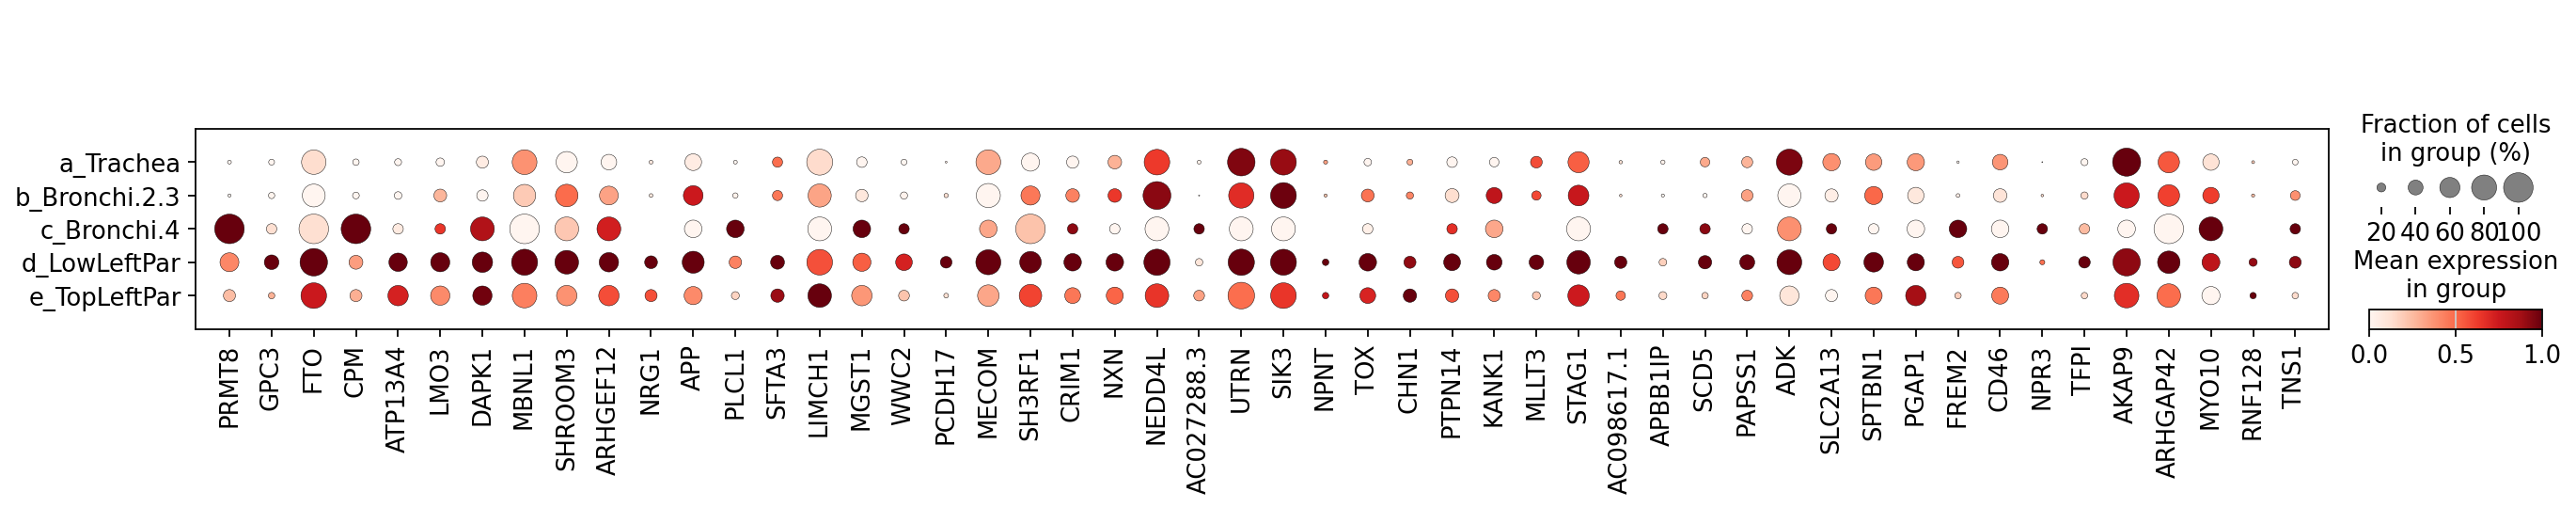

In [86]:
sc.pl.dotplot(Ciliated, groupby='Loc_true',var_names=results.sort_values('Z', ascending=False)[:50].index,standard_scale='var')

In [13]:
import numpy as np
import pandas as pd
def groupby_obs_var(adata, obs_name, var_names):
    # Extract observation data
    obs_data = adata.obs[obs_name]
    
    # Extract variable names data
    var_data = adata[:, var_names].X.toarray()
    
    # Convert to DataFrame
    var_df = Ciliated[:,var_names].to_df()
    
    # Concatenate observation data with variable data
    combined_df = pd.concat([obs_data, var_df], axis=1)
    
    # Group by the observation name and aggregate gene lists
    grouped_df = combined_df.groupby(obs_name).agg(lambda x: np.mean(x))
    
    return grouped_df

# Example usage
# Assuming 'adata' is your AnnData object, 'Loc_true' is your observation name, and var_names is a list of gene names
# adata = ad.read_h5ad('your_anndata_file.h5ad')


In [14]:
obs_name = 'Loc_true'
var_names = list(results.sort_values('Z', ascending=False).index)  # Replace with your gene names
grouped_df = groupby_obs_var(Ciliated, obs_name, var_names)

In [15]:
obs_data = Ciliated.obs[obs_name]


In [15]:
use_genes = list(grouped_df.columns[grouped_df.idxmax() == "d_LowLeftPar"])

In [2]:
import pandas as pd
results = pd.read_csv("./figures/Updated_folder/Updated_Ciliated_plots/Dataframe_Ciliated_HS_module_4_top_genes.csv")

In [6]:
use_genes = list(results.Gene)

In [4]:
import gseapy
import matplotlib.pyplot as plt

In [7]:
enr = gseapy.enrichr(gene_list=use_genes, # or "./tests/data/gene_list.txt",
                 gene_sets='WikiPathways_2024_Human',
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

/home/jovyan/my-conda-envs/general/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


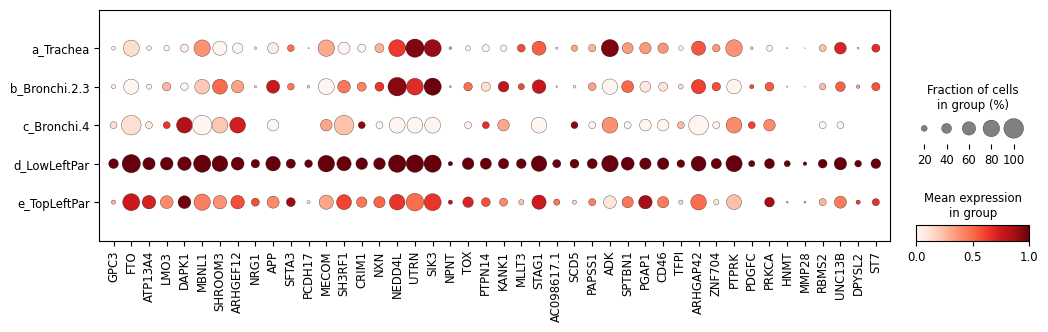

In [16]:
sc.pl.dotplot(Ciliated,groupby='Loc_true', var_names=use_genes[:44],standard_scale='var',figsize=(12,3))

In [17]:
enr.res2d

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2024_Human,Netrin UNC5B Signaling WP4747,3/52,0.000204,0.022806,0,0,29.726730,252.654841,ARHGEF12;DAPK1;PRKCA
1,WikiPathways_2024_Human,Axon Guidance WP5289,3/72,0.000533,0.029843,0,0,21.089077,158.951630,ARHGEF12;DPYSL2;PRKCA
2,WikiPathways_2024_Human,EGFR Tyrosine Kinase Inhibitor Resistance WP4806,3/84,0.000836,0.031207,0,0,17.953930,127.239388,PDGFC;NRG1;PRKCA
3,WikiPathways_2024_Human,TGF Beta Signaling Pathway WP366,3/132,0.003054,0.072067,0,0,11.246171,65.128728,APP;NEDD4L;SPTBN1
4,WikiPathways_2024_Human,Chronic Hyperglycemia Impairment Of Neuron Fun...,2/46,0.004604,0.072067,0,0,21.549784,115.956336,MMP28;PRKCA
...,...,...,...,...,...,...,...,...,...,...
107,WikiPathways_2024_Human,Alzheimer 39 S Disease And miRNA Effects WP2059,1/261,0.439320,0.451411,0,0,1.761717,1.449061,APP
108,WikiPathways_2024_Human,Alzheimer 39 S Disease WP5124,1/261,0.439320,0.451411,0,0,1.761717,1.449061,APP
109,WikiPathways_2024_Human,Focal Adhesion PI3K Akt mTOR Signaling WP3932,1/303,0.489533,0.498433,0,0,1.513476,1.081082,PDGFC
110,WikiPathways_2024_Human,Nuclear Receptors Meta Pathway WP2882,1/314,0.501940,0.506462,0,0,1.459469,1.005976,NRG1


In [18]:
highlight_terms = [
    "Netrin UNC5B Signaling WP4747", 
    "EGFR Tyrosine Kinase Inhibitor Resistance WP4806", 
]

In [21]:
data = enr.res2d[:100]

/tmp/ipykernel_208/2296832582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log10_adjusted_pvalue'] = -np.log10(data['Adjusted P-value'])


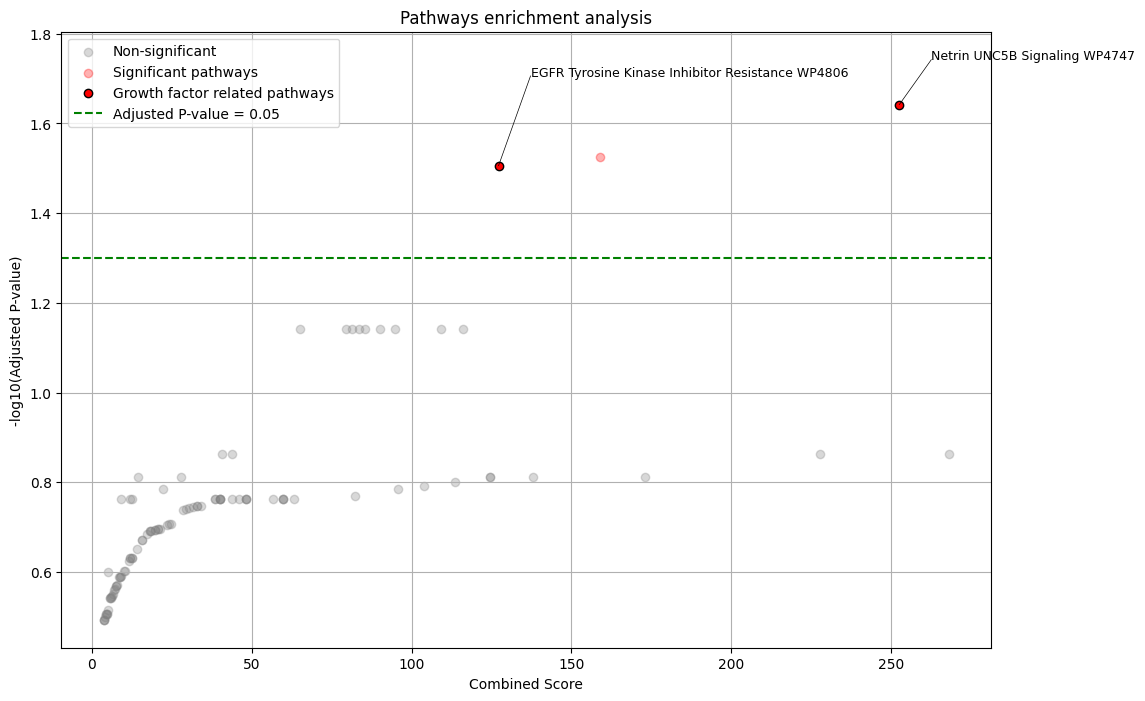

In [27]:
# Manually calculate -log10(Adjusted P-value) for sorting
data['log10_adjusted_pvalue'] = -np.log10(data['Adjusted P-value'])

highlighted_data = data[data.Term.isin(highlight_terms)]

# Sort the data by -log10(Adjusted P-value) to find the top 10
top_10_data = data.nlargest(10, 'log10_adjusted_pvalue')

# Create the plot with updated highlighting
plt.figure(figsize=(12,8))

# Plot non-significant points (Adjusted P-value >= 0.05) as grey with low opacity
non_significant = data[data['Adjusted P-value'] >= 0.05]
plt.scatter(non_significant['Combined Score'], 
            non_significant['log10_adjusted_pvalue'],
            color='grey', alpha=0.3, marker='o', label='Non-significant')

# Plot significant points that are not highlighted (Adjusted P-value < 0.05) as red with low opacity
significant = data[(data['Adjusted P-value'] < 0.05) & (~data['Term'].isin(highlight_terms))]
plt.scatter(significant['Combined Score'], 
            significant['log10_adjusted_pvalue'],
            color='red', alpha=0.3, marker='o', label='Significant pathways')

# Highlighted significant points with high opacity
highlighted_significant = data[(data['Adjusted P-value'] < 0.05) & (data['Term'].isin(highlight_terms))]
plt.scatter(highlighted_significant['Combined Score'], 
            highlighted_significant['log10_adjusted_pvalue'],
            color='red', alpha=1.0, marker='o', label='Growth factor related pathways', edgecolors='black')

# Add a line where Adjusted P-value = 0.05
plt.axhline(-np.log10(0.05), color='green', linestyle='--', label='Adjusted P-value = 0.05')

# Plot top 10 points and add text labels with connecting lines
for i, row in highlighted_data.iterrows():
#     plt.scatter(row['Combined Score'], row['log10_adjusted_pvalue'], color='blue', s=100)
    if i == 0:
        plt.text(row['Combined Score'] + 10, row['log10_adjusted_pvalue']+0.1, row['Term'], fontsize=9)
        plt.plot([row['Combined Score'], row['Combined Score'] + 10], 
             [row['log10_adjusted_pvalue'], row['log10_adjusted_pvalue']+0.1], 
             color='black', linestyle='-', linewidth=0.5)
    elif i ==20:
        plt.text(row['Combined Score'] + 10, row['log10_adjusted_pvalue']+0.3, row['Term'], fontsize=9)
        plt.plot([row['Combined Score'], row['Combined Score'] + 10], 
             [row['log10_adjusted_pvalue'], row['log10_adjusted_pvalue']+0.3], 
             color='black', linestyle='-', linewidth=0.5)
    else:
        plt.text(row['Combined Score'] + 10, row['log10_adjusted_pvalue']+0.2, row['Term'], fontsize=9)
        plt.plot([row['Combined Score'], row['Combined Score'] + 10], 
             [row['log10_adjusted_pvalue'], row['log10_adjusted_pvalue']+0.2], 
             color='black', linestyle='-', linewidth=0.5)
    

# Labeling the axes
plt.xlabel('Combined Score')
plt.ylabel('-log10(Adjusted P-value)')
plt.title('Pathways enrichment analysis')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from statannotations.Annotator import Annotator
import seaborn as sns
import scipy.stats as sci_stats

def label_plot_for_subcats(ax,gene):
    plt.title(gene, y=1.06)
    ax.set_ylabel("expression (log+1)")
    # ax.set_xlabel("cell type", labelpad=20)

def get_log_ax(label_plot_for_subcats,orient="v"):
    if orient == "v":
        figsize = (6, 6)
        set_scale = "set_yscale"
    else:
        figsize = (6, 6)
        set_scale = "set_xscale"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.patch.set_alpha(1)
    getattr(ax, set_scale)("log")
    return ax    

def plot_box_with_pvalue(data,x,y,gene,desired_order,colors_dict,save=None):

    plotting_parameters = {
        'data':    data,
        'x':       x,
        'y':       y,
        # 'palette': subcat_palette[1:]
    }
    # Calculate p-values for each pair of consecutive time points
    p_values = []
    
    # Convert 'new_celltype' column to categorical with desired order
#     data[x] = pd.Categorical(data[x], categories=desired_order, ordered=True)

    # Sort the DataFrame based on the categorical 'new_celltype' column
    data = data.sort_values(by=x)
    
    time_points = data[x].unique()
    print(time_points)
    for i in range(len(time_points) - 1):
        sample1 = data[data[x] == time_points[i]][y]
        sample2 = data[data[x] == time_points[i+1]][y]
        _, p = ttest_ind(sample1, sample2, equal_var=False)
        p_values.append(p)

    # Prepare pairs for annotator
    pairs = [(time_points[i], time_points[i+1]) for i in range(len(time_points) - 1)]

    # Transform each p-value to "p=" in scientific notation
    formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in p_values]

    with sns.plotting_context('notebook', font_scale = 1.4):
        # Create new plot
        ax = get_log_ax(gene)
        
        # Plot with seaborn
        sns.boxplot(**plotting_parameters,palette=colors_dict,)
        
        # Remove top and right border of the axis
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        sns.despine()
        
        
        # Add annotations
        annotator = Annotator(ax, pairs, **plotting_parameters)
        annotator.set_custom_annotations(formatted_pvalues)
        annotator.annotate()

        # Label and show
        label_plot_for_subcats(ax,gene)
    if save:
        plt.savefig(save)

    plt.show()

In [30]:
Growth_factor = list("ARHGEF12;DAPK1;PRKCA;PDGFC;NRG1;APP;NEDD4L;SPTBN1;KANK1;PTPN14".split(";"))

In [31]:
sc.tl.score_genes(Ciliated,Growth_factor,score_name='GF_score')

In [32]:
colors_dict = {
    'b_Bronchi.2.3':'#7570b3ff', 'c_Bronchi.4':'#66a61eff', 'd_LowLeftPar':'#a6761dff', 'e_TopLeftPar':'#666666ff', 'a_Trachea': '#1b9e77ff'
}

In [33]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

['a_Trachea', 'b_Bronchi.2.3', 'c_Bronchi.4', 'd_LowLeftPar', 'e_TopLeftPar']
Categories (5, object): ['a_Trachea', 'b_Bronchi.2.3', 'c_Bronchi.4', 'd_LowLeftPar', 'e_TopLeftPar']
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

a_Trachea vs. b_Bronchi.2.3: p=3.71e-24
b_Bronchi.2.3 vs. c_Bronchi.4: p=6.62e-02
c_Bronchi.4 vs. d_LowLeftPar: p=9.12e-02
d_LowLeftPar vs. e_TopLeftPar: p=6.44e-02


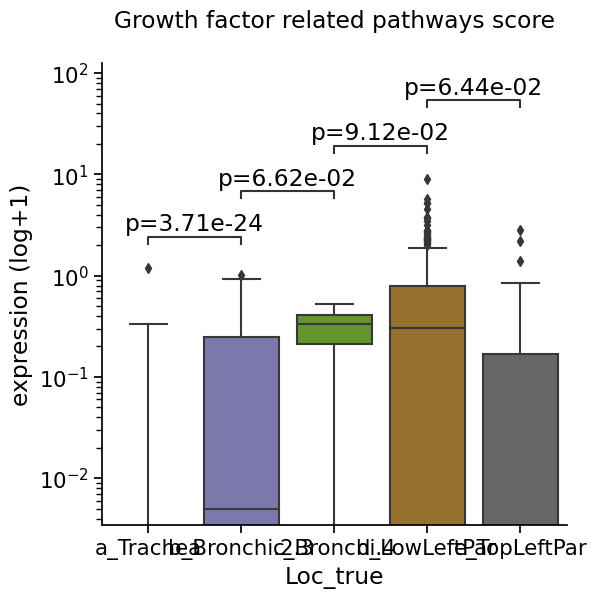

In [34]:
plot_box_with_pvalue(Ciliated.obs,'Loc_true','GF_score', 'Growth factor related pathways score',[],colors_dict)